In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

# import torch
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Good data
# df = pd.read_csv('./data/kokil dec 6 reprepare/affcon_final_with_linguistics.csv')

In [3]:
# Messy data
# df = pd.read_csv('./data/affcon_final_politeness_strategies_merge.csv')

In [4]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')

In [5]:
df = df.dropna()

In [6]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [7]:
######################################
## Weighted Onehot Encoding options ##
######################################
# During runtime: no need to edit anything in this cell

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text lenght #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

def set_OHE_pipeline_options(dataframe, option_TP, option_WT, option_PC, option_TL, option_k):
    ##############
    # Throughput #
    ##############
    df_throughput = dataframe[['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5']].copy()
    if option_TP == 'TP1':
        print("TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_throughput['avg_throughput'] = df_throughput.mean(axis=1)
        df_throughput['avg_throughput'] = df_throughput['avg_throughput'] / df_throughput['avg_throughput'].max()
    elif option_TP == 'TP2':
        print("TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_throughput['var_throughput'] = df_throughput.var(axis=1)
        print("Plot below: old throughput (x-axis) vs new throughput (y-axis)")
        plt.plot(df_throughput['var_throughput'], df_throughput['var_throughput'])
        df_throughput['var_throughput'] = df_throughput['var_throughput'] / df_throughput['var_throughput'].max()
    elif option_TP == 'TP3':
        print("TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_throughput['var_throughput'] = df_throughput.var(axis=1)
        max_val = df_throughput['var_throughput'].max()
        min_val = df_throughput['var_throughput'].min()
        tp_mid = ((max_val - min_val) // 2) + min_val
        tp_to_list = df_throughput['var_throughput'].tolist()

        amount_of_curve = option_k

        u_shaped_variance = []
        for each in tp_to_list:
            if each > tp_mid:
                u_shaped_variance.append((2*tp_mid - each)**(1/amount_of_curve))
            else:
                u_shaped_variance.append(each**(1/amount_of_curve))

        df_throughput['var_throughput_u_shaped'] = u_shaped_variance
        print("Plot below: old throughput (x-axis) vs new throughput (y-axis)")
        df_throughput.plot(x='var_throughput', y='var_throughput_u_shaped', style='o')
        df_throughput['var_throughput_u_shaped'] = df_throughput['var_throughput_u_shaped'] / df_throughput['var_throughput_u_shaped'].max()
        df_throughput = df_throughput.assign(var_throughput=df_throughput['var_throughput_u_shaped'])
    elif option_TP == 'TP4':
        print("TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_throughput['var_throughput'] = df_throughput.var(axis=1)
        max_val = df_throughput['var_throughput'].max()
        min_val = df_throughput['var_throughput'].min()
        tp_mid = ((max_val - min_val) // 2) + min_val
        tp_to_list = df_throughput['var_throughput'].tolist()

        amount_of_curve = option_k

        u_shaped_variance = []
        for each in tp_to_list:
            if each > tp_mid:
                u_shaped_variance.append((2*tp_mid - each)**(1/amount_of_curve))
            else:
                u_shaped_variance.append(each**(1/amount_of_curve))
        list_min = min(u_shaped_variance)
        list_max = max(u_shaped_variance)
        u_shaped_variance = (np.asarray(u_shaped_variance) * -1) +  list_min + list_max

        df_throughput['var_throughput_u_shaped'] = u_shaped_variance
        print("Plot below: old throughput (x-axis) vs new throughput (y-axis)")
        df_throughput.plot(x='var_throughput', y='var_throughput_u_shaped', style='o')
        df_throughput['var_throughput_u_shaped'] = df_throughput['var_throughput_u_shaped'] / df_throughput['var_throughput_u_shaped'].max()
        df_throughput = df_throughput.assign(var_throughput=df_throughput['var_throughput_u_shaped'])
    ############
    # Worktime #
    ############
    df_worktime = dataframe[['WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5']].copy()
    if option_WT == 'WT1':
        print("WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_worktime['avg_worktime'] = df_worktime.mean(axis=1)
        df_worktime['avg_worktime'] = df_worktime['avg_worktime'] / df_worktime['avg_worktime'].max()
    elif option_WT == 'WT2':
        print("WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_worktime['var_worktime'] = df_worktime.var(axis=1)
        df_worktime['var_worktime'] = df_worktime['var_worktime'] / df_worktime['var_worktime'].max()
    ################
    # PC agreement #
    ################
    df_agreement = dataframe[['Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 'Answer.3rapport.yes_pc_agree']].copy()
    if option_PC == 'PC1':
        print("PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_agreement['avg_agreement'] = df_agreement.mean(axis=1)
        df_agreement['avg_agreement'] = df_agreement['avg_agreement'] / df_agreement['avg_agreement'].max()
    elif option_PC == 'PC2':
        print("PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_agreement['var_agreement'] = df_agreement.var(axis=1)
        df_agreement['var_agreement'] = df_agreement['var_agreement'] / df_agreement['var_agreement'].max()
    elif option_PC == 'PC3':
        print("PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)")
        # Do nothing, df_agreement is ready as it is
    #####################
    # Input text lenght #
    #####################
    if option_TL == 'TL1':
        print("TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_textlenght = dataframe[['Input.num_characters']].copy()
        df_textlenght['Input.num_characters'] = df_textlenght['Input.num_characters'] / df_textlenght['Input.num_characters'].max()
    elif option_TL == 'TL2':
        print("TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)")
        df_textlenght = dataframe[['Input.num_words']].copy()
        df_textlenght['Input.num_words'] = df_textlenght['Input.num_words'] / df_textlenght['Input.num_words'].max()
    
    return df_throughput, df_worktime, df_agreement, df_textlenght

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


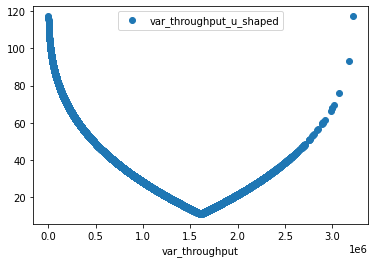

In [8]:
######################################
## Weighted Onehot Encoding options ##
######################################

# Select 1 option from each of the 3 variants above, e.g. TP2, WT1, PC3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

df_throughput, df_worktime, df_agreement, df_textlenght = set_OHE_pipeline_options(df, 'TP4', 'WT2', 'PC3', 'TL2', 3)

In [9]:
indices = range(df.shape[0])

In [10]:
train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
le = LabelEncoder()

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Individual Classifiers are LSTMS

In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

# tok.fit_on_texts(X_test_col)
X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.00001)
def create_lstm():
    Inp = Input(name='inputs', shape=[max_len])
    x = Embedding(max_words, 50, input_length=max_len)(Inp)
    x = LSTM(64, name='LSTM_01')(x)
    x = Dropout(0.5, name='Dropout')(x)
    x = Dense(128, activation='relu',name='Dense_01')(x)
    # x = Dropout(0.5,name='Dropout')(x)
    out = Dense(1,activation='softmax', name='output')(x)
    model = Model(inputs=Inp, outputs=out)
    
    return model

### Construct individual LSTM models

In [15]:
# Rapport model
rapport_model = create_lstm()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
rapport_model.fit(X_train,y_train_rapport,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_rapport), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 26ms/step - loss: 2.0781 - accuracy: 0.8637 - f1_m: 0.9276 - recall_m: 1.0000 - precision_m: 0.8656 - val_loss: 2.1660 - val_accuracy: 0.8580 - val_f1_m: 0.9229 - val_recall_m: 1.0000 - val_precision_m: 0.8576
Epoch 2/15
72/72 [==============================] - 1s 21ms/step - loss: 2.0781 - accuracy: 0.8637 - f1_m: 0.9276 - recall_m: 1.0000 - precision_m: 0.8656 - val_loss: 2.1660 - val_accuracy: 0.8580 - val_f1_m: 0.9229 - val_recall_m: 1.0000 - val_precision_m: 0.8576


In [16]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

In [17]:
rapport_pred_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [18]:
rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4289797713280563, 0.5, 0.4617751479289941, None)

In [19]:
# Game move model
gamemove_model = create_lstm()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
gamemove_model.fit(X_train,y_train_gamemove,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_gamemove), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 27ms/step - loss: 1.0483 - accuracy: 0.9313 - f1_m: 0.9648 - recall_m: 1.0000 - precision_m: 0.9322 - val_loss: 1.0864 - val_accuracy: 0.9288 - val_f1_m: 0.9629 - val_recall_m: 1.0000 - val_precision_m: 0.9286
Epoch 2/15
72/72 [==============================] - 2s 21ms/step - loss: 1.0483 - accuracy: 0.9313 - f1_m: 0.9648 - recall_m: 1.0000 - precision_m: 0.9322 - val_loss: 1.0864 - val_accuracy: 0.9288 - val_f1_m: 0.9629 - val_recall_m: 1.0000 - val_precision_m: 0.9286


In [20]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

In [21]:
gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.46437994722955145, 0.5, 0.48153214774281805, None)

In [22]:
# Reasoning model
reasoning_model = create_lstm()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
reasoning_model.fit(X_train,y_train_reasoning,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_reasoning), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 26ms/step - loss: 2.5712 - accuracy: 0.8314 - f1_m: 0.9088 - recall_m: 1.0000 - precision_m: 0.8337 - val_loss: 2.7360 - val_accuracy: 0.8206 - val_f1_m: 0.9007 - val_recall_m: 1.0000 - val_precision_m: 0.8199
Epoch 2/15
72/72 [==============================] - 2s 22ms/step - loss: 2.5712 - accuracy: 0.8314 - f1_m: 0.9088 - recall_m: 1.0000 - precision_m: 0.8337 - val_loss: 2.7360 - val_accuracy: 0.8206 - val_f1_m: 0.9007 - val_recall_m: 1.0000 - val_precision_m: 0.8199


In [23]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

In [24]:
reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.4102902374670185, 0.5, 0.4507246376811594, None)

In [25]:
# Share Information model
shareinfo_model = create_lstm()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
shareinfo_model.fit(X_train,y_train_share_information,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_share_information), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 26ms/step - loss: 2.4471 - accuracy: 0.8395 - f1_m: 0.9116 - recall_m: 1.0000 - precision_m: 0.8383 - val_loss: 2.3672 - val_accuracy: 0.8448 - val_f1_m: 0.9151 - val_recall_m: 1.0000 - val_precision_m: 0.8440
Epoch 2/15
72/72 [==============================] - 2s 22ms/step - loss: 2.4471 - accuracy: 0.8395 - f1_m: 0.9137 - recall_m: 1.0000 - precision_m: 0.8417 - val_loss: 2.3672 - val_accuracy: 0.8448 - val_f1_m: 0.9151 - val_recall_m: 1.0000 - val_precision_m: 0.8440


In [26]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

In [27]:
shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.4223834652594547, 0.5, 0.4579261025029797, None)

In [28]:
# Deception model
deception_model = create_lstm()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
deception_model.fit(X_train,y_train_deception,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_deception), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 26ms/step - loss: 0.7665 - accuracy: 0.9497 - f1_m: 0.9745 - recall_m: 1.0000 - precision_m: 0.9504 - val_loss: 0.6773 - val_accuracy: 0.9556 - val_f1_m: 0.9773 - val_recall_m: 1.0000 - val_precision_m: 0.9558
Epoch 2/15
72/72 [==============================] - 2s 21ms/step - loss: 0.7665 - accuracy: 0.9497 - f1_m: 0.9745 - recall_m: 1.0000 - precision_m: 0.9504 - val_loss: 0.6773 - val_accuracy: 0.9556 - val_f1_m: 0.9773 - val_recall_m: 1.0000 - val_precision_m: 0.9558


In [29]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.477792436235708, 0.5, 0.4886440296829323, None)

In [30]:
gamemove_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

### One hot encodings

In [31]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [32]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [33]:
def create_joint_model(df):
    inputB = Input(shape=(df.shape[1],))
    c = Dense(2, activation='relu')(inputB)
    c = Dense(4, activation='relu')(c)
    c = Dense(1, activation='softmax')(c)
    full_model = Model(inputs=inputB, outputs=c)

    full_model.compile(loss='binary_crossentropy', optimizer='adam', 
                          metrics=['acc',f1_m,precision_m, recall_m])
    
    return full_model

In [34]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df_full,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7665 - acc: 0.9497 - f1_m: 0.9742 - precision_m: 0.9501 - recall_m: 1.0000 - val_loss: 0.6773 - val_acc: 0.9556 - val_

In [35]:
joint_predict = joint_full_model.predict(pred_test_df_full)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.022207563764291997, 0.5, 0.04252631578947368, None)

In [36]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0781 - acc: 0.8637 - f1_m: 0.9269 - precision_m: 0.8646 - recall_m: 1.0000 - val_loss: 2.1660 - val_acc: 0.8580 - val_f1

In [37]:
joint_predict = joint_full_model.predict(pred_test_df)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07102022867194371, 0.5, 0.12437427801309203, None)

## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [38]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()

throughput_values = df_throughput['var_throughput'].take(indices_train).values
pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

worktime_values = df_worktime['var_worktime'].take(indices_train).values
pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values = df_agreement[df_agreement_keys[-1]].take(indices_train).values
    pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values, axis=0)
    pred_df_agreement = pred_df_throughput.mul(agreement_values, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values = df_agreement.take(indices_train)
    pred_df_full_agreement = np.multiply(pred_df_full_throughput, agreement_values)
    agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement = np.multiply(pred_df_throughput, agreement_values_wo_rapport)
    
textlenght_values = df_textlenght.take(indices_train).values
pred_df_full_textlenght = pred_df_full_throughput.mul(textlenght_values, axis=0)
pred_df_textlenght = pred_df_throughput.mul(textlenght_values, axis=0)

In [39]:
pred_df_agreement.head()

,gamemove,reasoning,shareinfo
0,0.101858,0.101858,0.101858
1,0.075764,0.056823,0.037882
2,0.514192,0.411353,0.411353
3,0.191510,0.153208,0.153208
4,0.113887,0.113887,0.170831


In [40]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()

throughput_values_test = df_throughput['var_throughput'].take(indices_test).values
pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

worktime_values_test = df_worktime['var_worktime'].take(indices_test).values
pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values_test = df_agreement[df_agreement_keys[-1]].take(indices_test).values
    pred_df_full_agreement_test = pred_df_full_throughput_test.mul(agreement_values_test, axis=0)
    pred_df_agreement_test = pred_df_throughput_test.mul(agreement_values_test, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values_test = df_agreement.take(indices_test)
    pred_df_full_agreement_test = np.multiply(pred_df_full_throughput_test, agreement_values_test)
    agreement_values_wo_rapport_test = agreement_values_test.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement_test = np.multiply(pred_df_throughput_test, agreement_values_wo_rapport_test)
    
textlenght_values_test = df_textlenght.take(indices_test).values
pred_df_full_textlenght_test = pred_df_full_throughput_test.mul(textlenght_values_test, axis=0)
pred_df_textlenght_test = pred_df_throughput_test.mul(textlenght_values_test, axis=0)

## Throughput only

### Joint Model with one hot encoding 

In [41]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_throughput_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7665 - acc: 0.9497 - f1_m: 0.9742 - precision_m: 0.9501 - recall_m: 1.0000 - val_loss: 0.6773 

In [42]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.022207563764291997, 0.5, 0.04252631578947368, None)

In [43]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [44]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_throughput_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0781 - acc: 0.8637 - f1_m: 0.9245 - precision_m: 0.8613 - recall_m: 1.0000 - val_loss: 2.1660 - 

In [45]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07102022867194371, 0.5, 0.12437427801309203, None)

## PC Agreement only

### Joint Model with one hot encoding 

In [46]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_agreement_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7665 - acc: 0.9497 - f1_m: 0.9742 - precision_m: 0.9501 - recall_m: 1.0000 - val_loss: 0.677

In [47]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07102022867194371, 0.5, 0.12437427801309203, None)

In [48]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [49]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_agreement_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0781 - acc: 0.8637 - f1_m: 0.9268 - precision_m: 0.8646 - recall_m: 1.0000 - val_loss: 2.1660 

In [50]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07102022867194371, 0.5, 0.12437427801309203, None)

## WorkTime only

### Joint Model with one hot encoding 

In [51]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_worktime_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7665 - acc: 0.9497 - f1_m: 0.9742 - precision_m: 0.9501 - recall_m: 1.0000 - val_loss: 0.6773 

In [52]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)


In [53]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_worktime_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0781 - acc: 0.8637 - f1_m: 0.9268 - precision_m: 0.8646 - recall_m: 1.0000 - val_loss: 2.1660 - 

In [54]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07102022867194371, 0.5, 0.12437427801309203, None)

## Text Length only

### Joint Model with one hot encoding 

In [55]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = create_joint_model(pred_df_full_textlenght)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlenght, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_textlenght_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7665 - acc: 0.9497 - f1_m: 0.9742 - precision_m: 0.9501 - recall_m: 1.0000 - val_loss: 0.6773 

In [56]:
joint_predict = joint_full_model.predict(pred_df_full_textlenght_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.022207563764291997, 0.5, 0.04252631578947368, None)

In [57]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [58]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = create_joint_model(pred_df_textlenght)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlenght, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_textlenght_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0781 - acc: 0.8637 - f1_m: 0.9268 - precision_m: 0.8646 - recall_m: 1.0000 - val_loss: 2.1660 - 

In [59]:
joint_predict = joint_full_model.predict(pred_df_textlenght_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07102022867194371, 0.5, 0.12437427801309203, None)